In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 100
plt.style.use("bmh")

In [3]:
os.chdir("..")

In [4]:
df = pd.read_csv("data/cleaned.csv", index_col=0)
df.reset_index(inplace=True, drop=True)

In [5]:
df.head()

,wiek,zawod,stan_cywilny,wyksztalcenie,ma_kredyt,kredyt_mieszkaniowy,ma_pozyczke,sposob_kontaktu,miesiac,day_of_week,dl_polaczenia,liczba_polaczen_aktualnej_kampanii,liczba_dni_od_ost_kontaktu,liczba_polaczen_przed_aktualna_kampania,wynik_poprzedniej_kampanii,wsk_zmien_zatrudnienia,wsk_cen_konsum,wsk_zauf_konsum,euribor3m,liczba_pracownikow,target
0,56,housemaid,married,basic.4y,1,1,1,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,37,services,married,high.school,1,0,1,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,40,admin.,married,basic.6y,1,1,1,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,56,services,married,high.school,1,1,0,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,59,admin.,married,professional.course,1,1,1,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


# Enkodowanie, standaryzacja

## Cechy numeryczne

### Licza\_dni\_od\_ost\_kontaktu

In [6]:
bins = [5, 10, 15, 20, 25, 30, 1000]

In [7]:
df.liczba_dni_od_ost_kontaktu = np.digitize(df.liczba_dni_od_ost_kontaktu, bins)

##### Wyjaśnienie
Zamieniamy liczbe dni od ostatniego kontaktu na zakresy w, których te kontakty się odbywały

### Wiek

In [8]:
ss = StandardScaler()

In [9]:
subset = ["euribor3m", "wiek", "liczba_pracownikow"]
subset.extend(df.columns[df.columns.str.startswith("wsk")])
subset

['euribor3m',
 'wiek',
 'liczba_pracownikow',
 'wsk_zmien_zatrudnienia',
 'wsk_cen_konsum',
 'wsk_zauf_konsum']

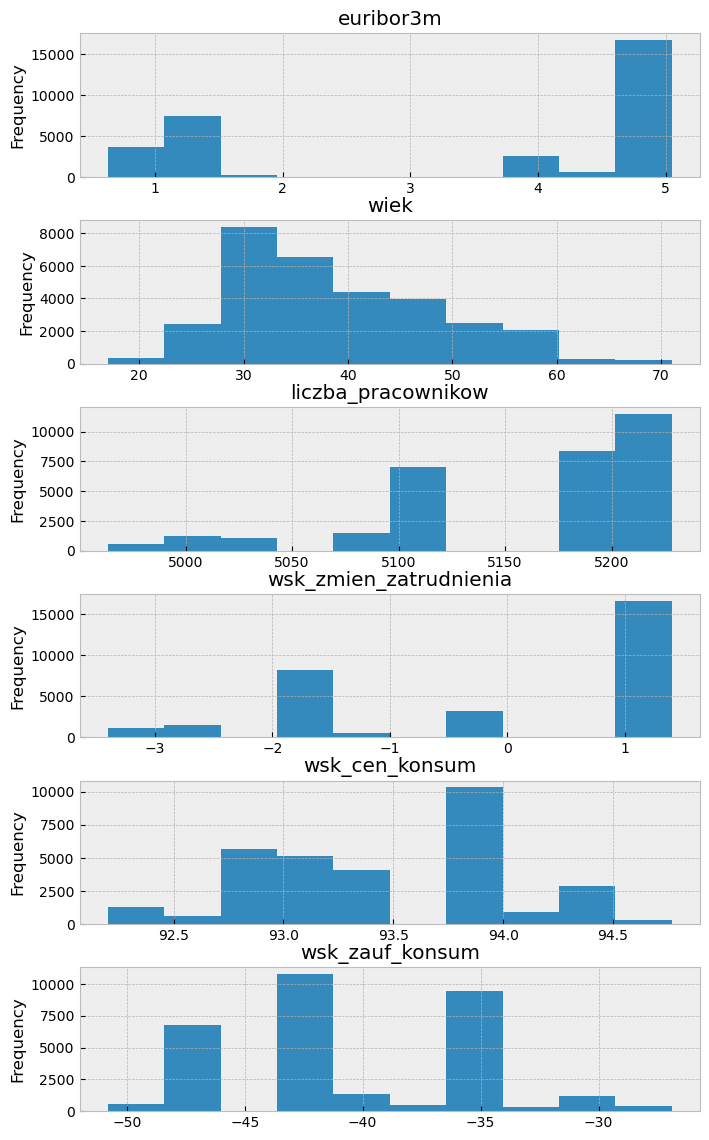

In [10]:
fig, axs = plt.subplots(len(subset), 1, figsize=(8, 14))


for ind, feature in enumerate(subset):
    df[feature].plot(kind="hist", ax=axs[ind], title=feature)

plt.subplots_adjust(hspace=0.3)

In [11]:
df.liczba_pracownikow = np.log(df.liczba_pracownikow)
df.wsk_zauf_konsum = ss.fit_transform(np.asarray(df.wsk_zauf_konsum).reshape(-1, 1))
df.wsk_cen_konsum = ss.fit_transform(np.asarray(df.wsk_cen_konsum).reshape(-1, 1))
df.wsk_zmien_zatrudnienia = np.log(df.wsk_zmien_zatrudnienia + 10)
df.wiek = ss.fit_transform(np.asarray(df.wiek).reshape(-1, 1))

##### Wyjasnienie
Używamy transformaty logarytmicznej dla zmiennych, które posiadają rozkład nie gaussowski, zaś standaryzacji wartości dla zmiennych o rozkładzie normalnym

## Cechy cykliczne

In [12]:
miesiace = {
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dec": 12,
}
df.miesiac = df.miesiac.map(miesiace) / 12 * np.pi
df.miesiac = np.sin(df.miesiac) * np.cos(df.miesiac)

##### Wyjaśnienie 
Musimy dokonać takiej transformacji ponieważ miesiące są cykliczne, nie możemy powiedzieć, że styczeń jest mniejszy od grudnia. Dlatego musimy dokonać transformacji sinusoidowej, dzięki model nie będzie uważał późniejszych miesięcy za coś większego

## Cechy kategoryczne (z pominieciem _wyksztalcenie_ i _zawod_, gdyz te beda poddane procesowi _feature enginnering_)

In [13]:
def pred_categorical_with_knn(df: pd.DataFrame, attrib: str, neighbours=3) -> None:
    model = KNeighborsClassifier(n_neighbors=3)
    X_train = df[~(df[attrib] == "unknown")]
    y_train = X_train[attrib]
    X_train = X_train.drop(attrib, axis=1)

    X_pred = df[df[attrib] == "unknown"]
    y_pred = X_pred[attrib]
    X_pred = X_pred.drop(attrib, axis=1)

    model.fit(X_train, y_train)
    df.loc[X_pred.index, attrib] = model.predict(X_pred)

In [14]:
df["aktywnie_pracujacy"] = ~df.zawod.isin(["student", "unemployed", "retired"]) + 0

In [15]:
subset = df.select_dtypes(include="object")
subset = subset[subset.columns.difference(["wyksztalcenie"])]

zawod_array = df.zawod

In [16]:
encoder = OneHotEncoder()
encoded_df = encoder.fit_transform(subset).toarray()
encoded_df = pd.DataFrame(encoded_df, columns=encoder.get_feature_names_out())
encoded_df = encoded_df.drop("sposob_kontaktu_cellular", axis=1)

df = df.join(encoded_df)
df = df.drop(subset.columns, axis=1)

### Wyksztalcenie (zamiana wartosci _unknown_, przy pomocy algorytmu __KNN__)

In [17]:
attrib = "wyksztalcenie"

In [18]:
pred_categorical_with_knn(df, attrib, 3)

In [19]:
df.wyksztalcenie.value_counts()

university.degree      10658
high.school             7864
basic.9y                4484
professional.course     4328
basic.4y                2415
basic.6y                1492
illiterate                11
Name: wyksztalcenie, dtype: int64

In [20]:
map_wyksztalcenie_do_liczby = {
    "illiterate": 0,
    "basic.4y": 1,
    "basic.6y": 2,
    "basic.9y": 3,
    "high.school": 4,
    "professional.course": 5,
    "university.degree": 6,
}

In [21]:
df.wyksztalcenie = df.wyksztalcenie.map(map_wyksztalcenie_do_liczby)

##### Wyjaśnienie
Wykształcenie jest atrybutem kategorycznym porządkowym, mapujemy go więc na liczby, które potem będziemy mogli łatwo porównywać

### Zawod

In [22]:
attrib = "zawod"

In [23]:
subset = df.columns.str.startswith("zawod")
df = df.iloc[:, ~subset]
df[attrib] = zawod_array

In [24]:
pred_categorical_with_knn(df, attrib)

In [25]:
df.zawod.value_counts()

admin.           8943
blue-collar      5954
technician       5604
services         2961
management       2393
entrepreneur     1119
self-employed    1101
retired           978
unemployed        754
student           734
housemaid         711
Name: zawod, dtype: int64

In [26]:
attrib = "zawod"
df = df.drop(attrib, axis=1).join(pd.get_dummies(df.zawod))

##### Wyjasnienie
Do modelu potrzebujemy nie mieć żadnych danych tekstowych w tabeli, więc trzeba przemapować kolumne zawód na dodatkowe kolumny unikatowych wartości zatrudnienia w których będzie wpisane 0 jeżeli nie pracuje w tym zawodzie i 1 jeżeli dany klient pracuje w tym zawodzie

In [27]:
df.head()

,wiek,wyksztalcenie,ma_kredyt,kredyt_mieszkaniowy,ma_pozyczke,miesiac,dl_polaczenia,liczba_polaczen_aktualnej_kampanii,liczba_dni_od_ost_kontaktu,liczba_polaczen_przed_aktualna_kampania,wsk_zmien_zatrudnienia,wsk_cen_konsum,wsk_zauf_konsum,euribor3m,liczba_pracownikow,target,aktywnie_pracujacy,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,sposob_kontaktu_telephone,stan_cywilny_divorced,stan_cywilny_married,stan_cywilny_single,stan_cywilny_unknown,wynik_poprzedniej_kampanii_failure,wynik_poprzedniej_kampanii_nonexistent,wynik_poprzedniej_kampanii_success,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,1.774340,1,1,1,1,0.25,261,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0
1,-0.178868,4,1,0,1,0.25,226,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0
2,0.129533,2,1,1,1,0.25,151,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0
3,1.774340,4,1,1,0,0.25,307,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0
4,2.082742,5,1,1,1,0.25,139,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0


In [28]:
# ProfileReport(df, dark_mode=True).to_widgets()

In [29]:
df.to_csv("data/totrain.csv")